<!--BOOK_INFORMATION-->
<a href="https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv" target="_blank"><img align="left" src="data/cover.jpg" style="width: 76px; height: 100px; background: white; padding: 1px; border: 1px solid black; margin-right:10px;"></a>
*This notebook contains an excerpt from the book [Machine Learning for OpenCV](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv) by Michael Beyeler.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/mbeyeler/opencv-machine-learning).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv)!*

<!--NAVIGATION-->
< [Measuring-Model-Performance-with-Scoring-Functions](03.01-Measuring-Model-Performance-with-Scoring-Functions.ipynb) | [Contents](../README.md) | [Using Regression Models to Predict Continuous Outcomes](03.03-Using-Regression-Models-to-Predict-Continuous-Outcomes.ipynb) >

# Understanding the k-NN Classifier

The $k$-NN algorithm is arguably one of the simplest machine learning algorithms. The
reason for this is that we basically only need to store the training dataset. Then, in order to
make a prediction for a new data point, we only need to find the closest data point in the
training dataset-its **nearest neighbor**.

In a nutshell, the $k$-NN algorithm argues that a data point probably belongs to the same
class as its neighbors.
Of course, some neighborhoods might be a little more complicated. In this case, we would
not just consider our closest neighbor (where $k=1$), but instead our $k$ nearest neighbors.

That's all there is to it.

## Implementing k-NN in OpenCV

Using OpenCV, we can easily create a $k$-NN model via the function `cv2.ml.KNearest_create`. Building the model then involves the following steps:
- Generate some training data.
- Create a k-NN object for a given number k.
- Find the k nearest neighbors of a new data point that we want to classify.
- Assign the class label of the new data point by majority vote.
- Plot the result.

We first import all the necessary modules: OpenCV for the $k$-NN algorithm, NumPy for
data munging, and Matplotlib for plotting. If you are working in a Jupyter Notebook, don't
forget to call the `%matplotlib inline` magic:

In [3]:
# OpenCVにおけるk-NNアルゴリズムの実装
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.style.use('ggplot')

### Generating the training data

The first step is to generate some training data. For this, we will use NumPy's random
number generator. As discussed in the previous section, we will fix the seed of the random
number generator, so that re-running the script will always generate the same values:

In [5]:
# 学習データの生成
np.random.seed(42)

We can pick a single data point with `0 <= x <= 100` and `0 <= y <= 100`:

In [6]:
single_data_point = np.random.randint(0, 100, 2)
single_data_point

array([51, 92])

As shown in the preceding output, this will pick two random integers between 0 and 100.
We will interpret the first integer as the data point's $x$ coordinate on the map, and the
second integer as the point's $y$ coordinate. Similarly, let's pick a label for the data point:

In [7]:
single_label = np.random.randint(0, 2)
single_label

0

Turns out that this data point would have class 0.

Let's wrap this process in a function that takes as input the number of data points to
generate (that is, `num_samples`) and the number of features every data point has (that is,
`num_features`):

In [8]:
def generate_data(num_samples, num_features=2):
    """Randomly generates a number of data points"""
    data_size = (num_samples, num_features)
    train_data = np.random.randint(0, 100, size=data_size)
    labels_size = (num_samples, 1)
    labels = np.random.randint(0, 2, size=labels_size)
    
    return train_data.astype(np.float32), labels

Let's put the function to test and generate an arbitrary number of data points, let's say
eleven, whose coordinates are chosen randomly:

In [9]:
train_data, labels = generate_data(11)
train_data

array([[71., 60.],
       [20., 82.],
       [86., 74.],
       [74., 87.],
       [99., 23.],
       [ 2., 21.],
       [52.,  1.],
       [87., 29.],
       [37.,  1.],
       [63., 59.],
       [20., 32.]], dtype=float32)

As we can see from the preceding output, the `train_data` variable is an 11 x 2 array, where
each row corresponds to a single data point. We can also inspect the first data point with its
corresponding label by indexing into the array:

In [10]:
train_data[0], labels[0]

(array([71., 60.], dtype=float32), array([1]))

This tells us that the first data point is a blue square (because it has class 0) and lives at
location $(x, y) = (71, 60)$ on the town map. If we want, we can plot this data point on
the town map using Matplotlib:

Text(0, 0.5, 'y coordinate')

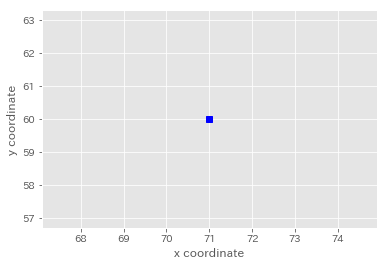

In [11]:
plt.plot(train_data[0, 0], train_data[0, 1], 'sb')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')

But what if we want to visualize the whole training set at once? Let's write a function for
that. The function should take as input a list of all the data points that are blue squares
(`all_blue`) and a list of the data points that are red triangles (`all_red`):

In [12]:
def plot_data(all_blue, all_red):
    plt.figure(figsize=(10, 6))
    plt.scatter(all_blue[:, 0], all_blue[:, 1], c='b', marker='s', s=180)
    plt.scatter(all_red[:, 0], all_red[:, 1], c='r', marker='^', s=180)
    plt.xlabel('x coordinate (feature 1)')
    plt.ylabel('y coordinate (feature 2)')

Let's try it on our dataset! First we have to split all the data points into red and blue sets. We
can quickly select all the elements of the `labels` array created earlier that are equal to 0,
using the following command (where `ravel` flattens the array):

In [13]:
labels.ravel() == 0

array([False, False, False,  True, False,  True,  True,  True,  True,
        True, False])

All the blue data points are then all the rows of the `train_data` array created earlier,
whose corresponding label is 0:

In [21]:
blue = train_data[labels.ravel() == 0]
print('blue\n', blue)
print('train_data\n', train_data)
print('labels\n', labels)

blue
 [[74. 87.]
 [ 2. 21.]
 [52.  1.]
 [87. 29.]
 [37.  1.]
 [63. 59.]]
train_data
 [[71. 60.]
 [20. 82.]
 [86. 74.]
 [74. 87.]
 [99. 23.]
 [ 2. 21.]
 [52.  1.]
 [87. 29.]
 [37.  1.]
 [63. 59.]
 [20. 32.]]
labels
 [[1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]]


The same can be done for all the red data points:

In [22]:
red = train_data[labels.ravel() == 1]
print('red\n', red)

red
 [[71. 60.]
 [20. 82.]
 [86. 74.]
 [99. 23.]
 [20. 32.]]


Finally, let's plot all the data points:

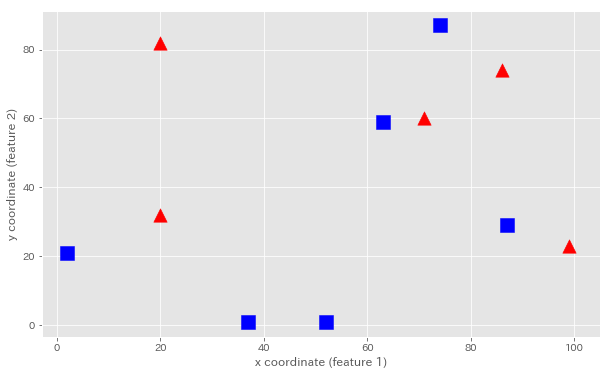

In [23]:
plot_data(blue, red)

### Training the classifier

Now it's time to train the classifier.

As all other machine learning functions, the $k$-NN classifier is part of OpenCV 3.1's `ml` module. You can create a new classifier using the following command:

In [24]:
knn = cv2.ml.KNearest_create()

We then pass our training data to the train method:

In [25]:
knn.train(train_data, cv2.ml.ROW_SAMPLE, labels)

True

Here, we have to tell knn that our data is an $N \times 2$ array (that is, every row is a data point).
Upon success, the function returns True.

### Predicting the label of a new data point

The other really helpful method that `knn` provides is called `findNearest`. It can be used to
predict the label of a new data point based on its nearest neighbors.

Thanks to our `generate_data` function, it is actually really easy to generate a new data
point! We can think of a new data point as a dataset of size 1:

In [26]:
newcomer, _ = generate_data(1)
newcomer

array([[91., 59.]], dtype=float32)

Our function also returns a random label, but we are not interested in that. Instead, we
want to predict it using our trained classifier! We can tell Python to ignore an output value
with an underscore (`_`).

Let's have a look at our town map again. We will plot the training set as we did earlier, but
also add the new data point as a green circle (since we don't know yet whether it is
supposed to be a blue square or a red triangle):

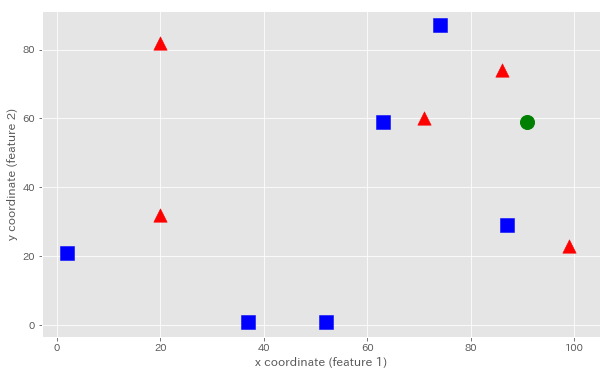

In [27]:
plot_data(blue, red)
plt.plot(newcomer[0, 0], newcomer[0, 1], 'go', markersize=14);

If you had to guess based on its neighbors, what label would you assign the new data pointblue
or red?

Well, it depends, doesn't it? If we look at the house closest to it (the one living roughly at $(x,
y) = (85, 75)$), we would probably assign
the new data point to be a red triangle as well. This is exactly what our classifier would
predict for $k=1$:

In [19]:
ret, results, neighbor, dist = knn.findNearest(newcomer, 1)
print("Predicted label:\t", results)
print("Neighbor's label:\t", neighbor)
print("Distance to neighbor:\t", dist)

Predicted label:	 [[ 1.]]
Neighbor's label:	 [[ 1.]]
Distance to neighbor:	 [[ 250.]]


Here, knn reports that the nearest neighbor is 250 arbitrary units away, that the neighbor
has label 1 (which we said corresponds to red triangles), and that therefore the new data
point should also have label 1. The same would be true if we looked at the $k=2$ nearest
neighbors, and the $k=3$ nearest neighbors.

But we want to be careful not to pick arbitrary
even numbers for $k$. Why is that? Refer to page 64 for the answer.

Finally, what would happen if we dramatically widened our search window and classified
the new data point based on its $k=7$ nearest neighbors (circled with a solid line in the figure
mentioned earlier)?

Let's find out by calling the `findNearest` method with $k=7$ neighbors:

In [20]:
ret, results, neighbor, dist = knn.findNearest(newcomer, 7)
print("Predicted label:\t", results)
print("Neighbor's label:\t", neighbor)
print("Distance to neighbor:\t", dist)

Predicted label:	 [[ 0.]]
Neighbor's label:	 [[ 1.  1.  0.  0.  0.  1.  0.]]
Distance to neighbor:	 [[  250.   401.   784.   916.  1073.  1360.  4885.]]


Suddenly, the predicted label is 0 (blue square). The reason is that we now have four
neighbors within the solid circle that are blue squares (label 0), and only three that are red
triangles (label 1). So the majority vote would suggest making the newcomer a blue square
as well.

For $k=6$, there is a tie:

In [21]:
ret, results, neighbors, dist = knn.findNearest(newcomer, 6)
print("Predicted label:\t", results)
print("Neighbors' labels:\t", neighbors)
print("Distance to neighbors:\t", dist)

Predicted label:	 [[ 0.]]
Neighbors' labels:	 [[ 1.  1.  0.  0.  0.  1.]]
Distance to neighbors:	 [[  250.   401.   784.   916.  1073.  1360.]]


Alternatively, predictions can be made with the `predict` method. But first, need to set `k`:

In [22]:
knn.setDefaultK(7)
knn.predict(newcomer)

(0.0, array([[ 0.]], dtype=float32))

In [23]:
knn.setDefaultK(6)
knn.predict(newcomer)

(0.0, array([[ 0.]], dtype=float32))

As you can see, the outcome of $k$-NN changes with the number $k$. However, often we do not
know beforehand which number $k$ is the most suitable. A naive solution to this problem is
just to try a bunch of values for $k$, and see which one performs best. We will learn more
sophisticated solutions in later chapters of this book.

<!--NAVIGATION-->
< [Measuring-Model-Performance-with-Scoring-Functions](03.01-Measuring-Model-Performance-with-Scoring-Functions.ipynb) | [Contents](../README.md) | [Using Regression Models to Predict Continuous Outcomes](03.03-Using-Regression-Models-to-Predict-Continuous-Outcomes.ipynb) >